In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
from resizeimage import resizeimage
import cv2
import os
from IPython.display import clear_output
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
X_train = np.load("data_raw/X_train.npy")
y_train = np.load("data_raw/y_train.npy")


In [9]:
X_nor = X_train[y_train == 0]
X_bac = X_train[y_train == 1]
X_vir = X_train[y_train == 2]

y_nor = y_train[y_train == 0]
y_bac = y_train[y_train == 1]
y_vir = y_train[y_train == 2]

X_bac_rec = X_bac[:1345]
y_bac_rec = y_bac[:1345]

X_train_rec = np.concatenate([X_nor, X_bac_rec, X_vir])
y_train_rec = np.concatenate([y_nor, y_bac_rec, y_vir])

In [11]:
print(X_train_rec[y_train_rec == 0].shape, X_train_rec[y_train_rec == 1].shape, X_train_rec[y_train_rec == 2].shape)

(1341, 50176) (1345, 50176) (1345, 50176)


In [17]:
pca = PCA(n_components=500)
pca.fit(X_train_rec)

PCA(n_components=500)

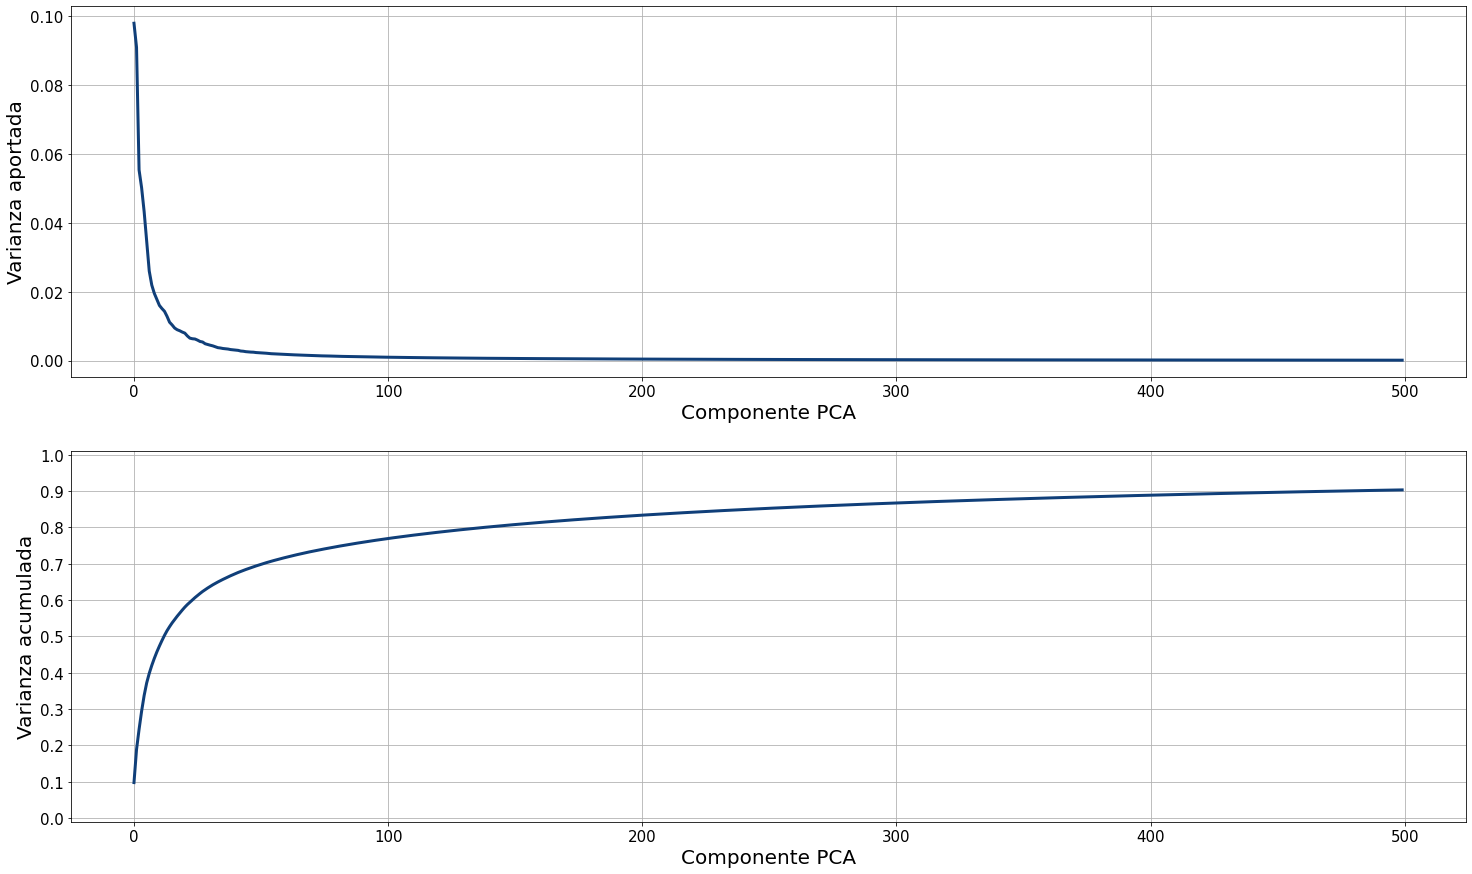

In [18]:
%matplotlib inline


fig, (ax1, ax2) = plt.subplots(2, figsize=(25,15))
ax1.plot(pca.explained_variance_ratio_, linewidth=3, color="#103f79")

ax1.grid()
ax1.tick_params(labelsize=15)
ax1.set_xlabel("Componente PCA", fontsize=20)
ax1.set_ylabel("Varianza aportada", fontsize=20)


acumulada = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(acumulada, linewidth=3, color="#103f79")
ax2.grid()
ax2.tick_params(labelsize=15)
ax2.set_xlabel("Componente PCA", fontsize=20)
ax2.set_ylabel("Varianza acumulada", fontsize=20)
ax2.set_ylim([-0.01,1.01])
ax2.set_yticks(np.arange(0, 1.1, 0.1))
plt.show()

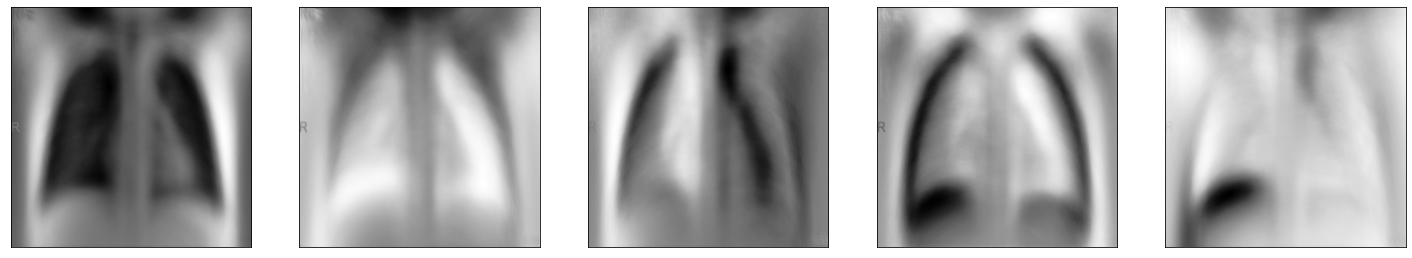

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(25,5))
for index in range(5):
  ax[index].imshow(pca.components_[index].reshape(224,224), cmap="Greys_r")
  ax[index].set_xticks([])
  ax[index].set_yticks([])
plt.show()

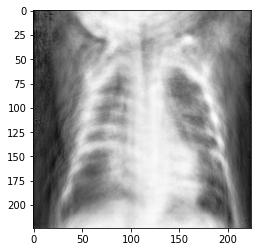

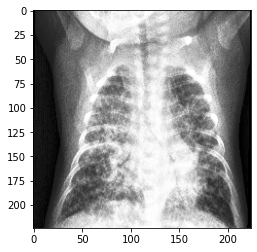

In [23]:
X_pca = pca.transform(X_train_rec)
X_reconstruido = pca.inverse_transform(X_pca[-1])

plt.imshow(X_reconstruido.reshape(224,224), cmap="Greys_r")
plt.show()
plt.imshow(X_train_rec[-1].reshape(224,224), cmap="Greys_r")
plt.show()

In [1]:

fig, ax = plt.subplots(1, figsize=(10,10))

#ax.scatter(X_pca[:,0], X_pca[:,1], c=y_train)
ax.scatter(X_pca[y_train_rec == 0][:,0], X_pca[y_train_rec == 0][:,1], c="red", alpha=1, label="Normal")
ax.scatter(X_pca[y_train_rec == 1][:,0], X_pca[y_train_rec == 1][:,1], c="b", alpha=0.5,label="bacteria")
ax.scatter(X_pca[y_train_rec == 2][:,0], X_pca[y_train_rec == 2][:,1], c="y", alpha=1, label="viral")
ax.legend()
plt.show()

NameError: name 'plt' is not defined

In [33]:
print(X_train_rec[y_train_rec == 0].shape, X_train_rec[y_train_rec == 1].shape, X_train_rec[y_train_rec == 2].shape)


(1341, 50176) (1345, 50176) (1345, 50176)


In [35]:
np.save("data_pca/X_pca_3clases", X_pca)
np.save("data_pca/y_train_rec_3clases", y_train_rec)

In [37]:
X_test = np.load("data_raw/X_test.npy")
y_test = np.load("data_raw/y_test.npy")
y_test_oh = np.load("data_raw/y_test_oh.npy")

In [38]:
X_pca_test = pca.transform(X_test)

In [39]:
np.save("data_pca/X_pca_test_3clases", X_pca_test)
np.save("data_pca/y_test_oh_3clases", y_test_oh)
np.save("data_pca/y_test_3clases", y_test)